In [ ]:
import os
import matplotlib.pyplot as plt

from lsmcpp.solution import *
from lsmcpp.local_search import *
from lsmcpp.conflict_solver.high_level_planner import PBS
from lsmcpp.conflict_solver.low_level_planner import *
from lsmcpp.benchmark.simulation import simulate
from lsmcpp.benchmark.instance import MCPP

### load the floor_small MCPP instance

Archive:  data/data.zip
   creating: data/instances/
  inflating: data/__MACOSX/._instances  
   creating: data/instances/Shanghai2/
  inflating: data/__MACOSX/instances/._Shanghai2  
  inflating: data/instances/AR0701SR.mcpp  
  inflating: data/__MACOSX/instances/._AR0701SR.mcpp  
  inflating: data/instances/floor_large.mcpp  
  inflating: data/__MACOSX/instances/._floor_large.mcpp  
  inflating: data/instances/Shanghai2.mcpp  
  inflating: data/__MACOSX/instances/._Shanghai2.mcpp  
  inflating: data/instances/ost002d.mcpp  
  inflating: data/__MACOSX/instances/._ost002d.mcpp  
  inflating: data/instances/floor_small.mcpp  
  inflating: data/__MACOSX/instances/._floor_small.mcpp  
  inflating: data/instances/AR0205SR.mcpp  
  inflating: data/__MACOSX/instances/._AR0205SR.mcpp  
   creating: data/instances/NewYork1/
  inflating: data/__MACOSX/instances/._NewYork1  
   creating: data/instances/ost002d/
  inflating: data/__MACOSX/instances/._ost002d  
   creating: data/instances/CPP/
  i

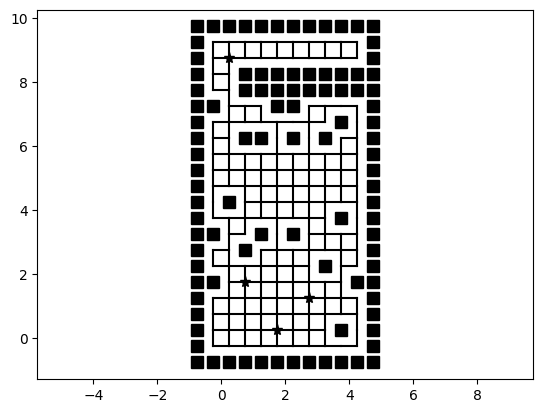

In [4]:
name = "floor_small"

# Unzip data files
if not os.path.exists(f"data/gridmaps/{name}.map"):
    import subprocess
    subprocess.call(["unzip", "-o", "data/data.zip", "-d", "data"])

mcpp = MCPP.read_instance(os.path.join("data", "instances", f"{name}.mcpp"))

rmv_ratio, seed = 0.1, 2
mutant = list(mcpp.randomized_mutants([rmv_ratio], [seed]))[0]

fig, ax = plt.subplots()
mutant.draw(ax)

### Run LS-MCPP with MFC as initial solution

- Rooted-Tree-Cover, R=[(1, 2), (3, 1), (0, 9), (2, 0)], B=3
--- # of deleted edges of weight > 3: 0
> B is too low, # of subtrees: 17 > 4
- Rooted-Tree-Cover, R=[(1, 2), (3, 1), (0, 9), (2, 0)], B=70.0
--- # of deleted edges of weight > 70.0: 0
--- leftover subtree: 27 nodes, 26 edges, 38 weights
--- leftover subtree: 13 nodes, 12 edges, 16 weights
--- leftover subtree: 6 nodes, 5 edges, 5 weights
--- leftover subtree: 1 nodes, 0 edges, 0 weights
> B: 70.0, max weights: 38
- Rooted-Tree-Cover, R=[(1, 2), (3, 1), (0, 9), (2, 0)], B=34.0
--- # of deleted edges of weight > 34.0: 0
--- matched subtree ((1, 2)=>(1, 2)): 28 nodes, 26 edges, 38 weights
--- leftover subtree: 13 nodes, 12 edges, 16 weights
--- leftover subtree: 6 nodes, 5 edges, 5 weights
--- leftover subtree: 1 nodes, 0 edges, 0 weights
> B: 34.0, max weights: 38
- Rooted-Tree-Cover, R=[(1, 2), (3, 1), (0, 9), (2, 0)], B=16.0
--- # of deleted edges of weight > 16.0: 0
--- matched subtree ((1, 2)=>(2, 2)): 22 nodes, 21 edges, 

(np.float64(-1.025), np.float64(5.025), np.float64(-1.275), np.float64(10.275))

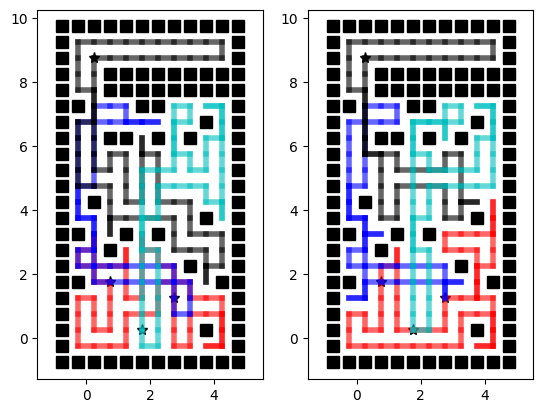

In [5]:
init_sol = MFC_sol(mutant)
ls_mcpp_planner = LocalSearchMCPP(mutant, init_sol, PrioType.CompositeHeur, PoolType.VertexEdgewise)
M = 2000
sol_opt, rt = ls_mcpp_planner.run(
    M=M,
    S=int(M // 20),
    alpha=np.exp(np.log(0.2) / M),
    gamma=0.01,
    sample_type=SampleType.RouletteWheel
)

colors = ["r", "b", "k", "c"]
fig, axs = plt.subplots(1, 2)
for i, r in enumerate(mutant.R):
    r = mutant.legacy_vertex(r)
    axs[0].plot(r[0], r[1], "*k", ms=8, mfc=colors[i])

for v in mutant.static_obstacles:
    px, py = (v[0] - 0.5) / 2, (v[1] - 0.5) / 2
    axs[0].plot(px, py, "ks", ms=8)

for i in range(mutant.k):
    pi = init_sol.Pi[i]
    for j in range(len(pi)-1):
        axs[0].plot([pi[j][0], pi[j+1][0]], [pi[j][1], pi[j+1][1]], color=f'{colors[i]}', linewidth=4, alpha=0.6)
axs[0].axis("equal")

for i, r in enumerate(mutant.R):
    r = mutant.legacy_vertex(r)
    axs[1].plot(r[0], r[1], "*k", ms=8, mfc=colors[i])

for v in mutant.static_obstacles:
    px, py = (v[0] - 0.5) / 2, (v[1] - 0.5) / 2
    axs[1].plot(px, py, "ks", ms=8)

for i in range(mutant.k):
    pi = sol_opt.Pi[i]
    for j in range(len(pi)-1):
        axs[1].plot([pi[j][0], pi[j+1][0]], [pi[j][1], pi[j+1][1]], color=f'{colors[i]}', linewidth=4, alpha=0.6)
axs[1].axis("equal")

### Run decoflicting using PBS + adaptive low-level planner

In [ ]:
plans = []
for i in mutant.I:
    P = Plan.construct_from_path(sol_opt.Pi[i], mutant)
    plans.append(
        Plan([State(mutant.legacy_vertex(X.pos), X.time, X.heading) for X in P.states]))

# record the simulation of the undeconflicted LS-MCPP solution
simulate(mutant, plans, 3, 0.1, "LS-MCPP")  # stored in data/videos

pp = PBS(mutant, AdaptiveApproach(mutant, HeurType.TrueDist))
plans = pp.run(sol_opt, verbose=True)

# record the simulation of the conflicted LS-MCPP solution
simulate(mutant, plans, 3, 0.1, "adaptive") # stored in data/videos
